In [11]:
import os
from collections import Counter
import calendar

from scipy import stats 
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import dask.dataframe as dd

In [12]:
'''Dataset preparation'''


def replace_non_digit_string(data_frame):
    # replace all cells without numbers with NA
    
    mask = ~data_frame[['Height', 'BirthDate']].apply(lambda col: col.astype(str).str.contains(r'\d')).any(axis=1)
    return data_frame[~mask]

def remove_empty_strings(data_frame):
    # remove all empty strings
    
    data_frame = data_frame.dropna(how='all')
    return data_frame

def remove_duplicates(date_frame):
    # remove all duplicates
    
    date_frame = date_frame.drop_duplicates()
    return date_frame

def remove_by_time(data_frame):
    # delete all lines between 1:00:00 and 3:00:00
    
    start_time = pd.to_datetime('01:00:00').time()
    end_time = pd.to_datetime('03:00:00').time()

    data_frame['BirthDate'] = pd.to_datetime(data_frame['BirthDate'], errors='coerce')

    mask = (data_frame['BirthDate'].notna()) & (data_frame['BirthDate'].dt.time >= start_time) & (data_frame['BirthDate'].dt.time <= end_time)
    return data_frame[~mask]


In [13]:
# prepare the dataset
df = pd.read_csv('.test_data_set.csv')

df.fillna('')

df = replace_non_digit_string(df)   
df = remove_empty_strings(df)
df = remove_duplicates(df)
df = remove_by_time(df)


# get unique rows for every hour, get median values, get mean values and mergin metrics and dataset
def metrics_calculation(data_frame):
   
    data_frame['Hour'] = pd.to_datetime(data_frame['BirthDate']).dt.hour
   
    grouped = data_frame.groupby('Hour')

    result = pd.DataFrame({
        'UniqueCounts': grouped['Name'].nunique(),
        'MeanValues': grouped['Height'].mean(),
        'MedianValues': grouped['Height'].median()
    })

    return result

metrics = metrics_calculation(df)
df = df.join(metrics, on='Hour', how='inner')
df.head()


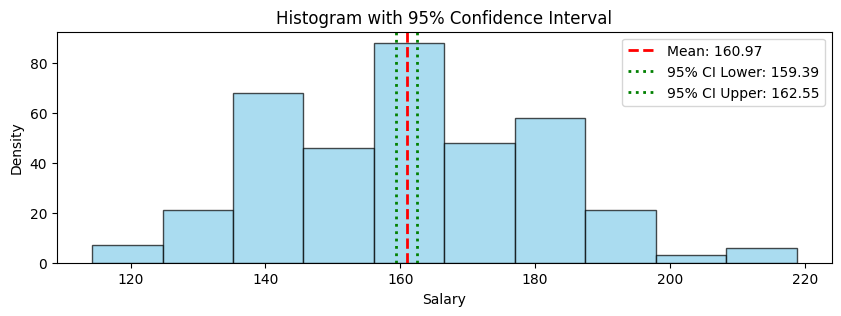

In [20]:
'''
Having a large sample and normal distribution of data, 
I calculated a confidence interval based on the sample - I used the z-distribution.
'''

sample = df['Height']

# calculate mean and standart deviation
mean = np.mean(sample)
std_dev = np.std(sample, ddof=1)
n = len(sample)

# calculate of 95% confidience interval
confidience_level = 0.95
Z = stats.norm.ppf((1 + confidience_level)/2)

# formula for confidience interval
margin_of_error = Z * (std_dev / np.sqrt(n))
confidience_interval = (mean - margin_of_error, mean + margin_of_error)

plt.figure(figsize=(10, 3))

plt.hist(sample, bins=10, color='skyblue', alpha=0.7, edgecolor='black')
plt.axvline(mean, color='red', linestyle='dashed', linewidth=2, label=f'Mean: {mean:.2f}')
plt.axvline(confidience_interval[0], color='green', linestyle='dotted', linewidth=2, label=f'95% CI Lower: {confidience_interval[0]:.2f}')
plt.axvline(confidience_interval[1], color='green', linestyle='dotted', linewidth=2, label=f'95% CI Upper: {confidience_interval[1]:.2f}')
plt.title('Histogram with 95% Confidence Interval')
plt.xlabel('Salary')
plt.ylabel('Density')
plt.legend()
plt.show()

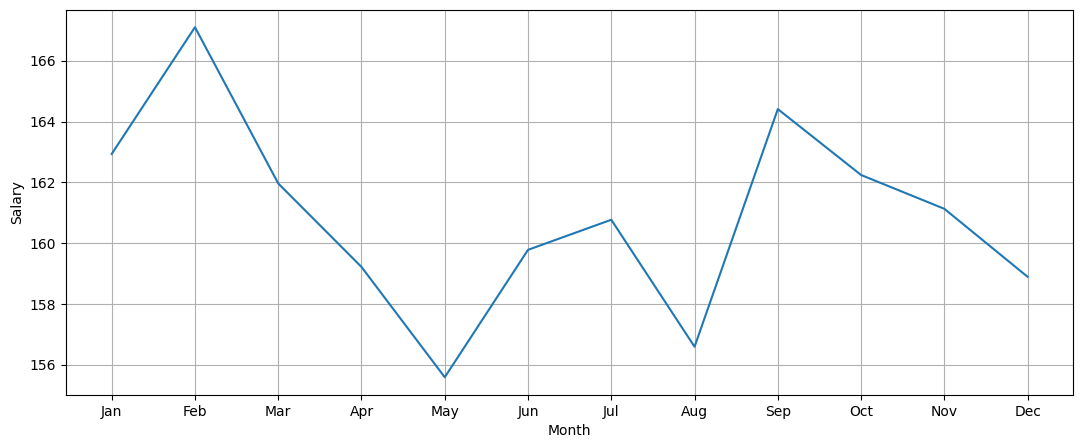

In [21]:
df['BirthDate'] = pd.to_datetime(df['BirthDate'])
df['month'] = df['BirthDate'].dt.month
monthly_mean = df.groupby('month')['Height'].mean()

monthly_mean.index = [calendar.month_abbr[int(month)] for month in monthly_mean.index]

plt.figure(figsize=(13, 5))

plt.plot(monthly_mean.index, monthly_mean.values)
plt.xlabel('Month')
plt.ylabel('Salary')
plt.grid(True)
plt.show()


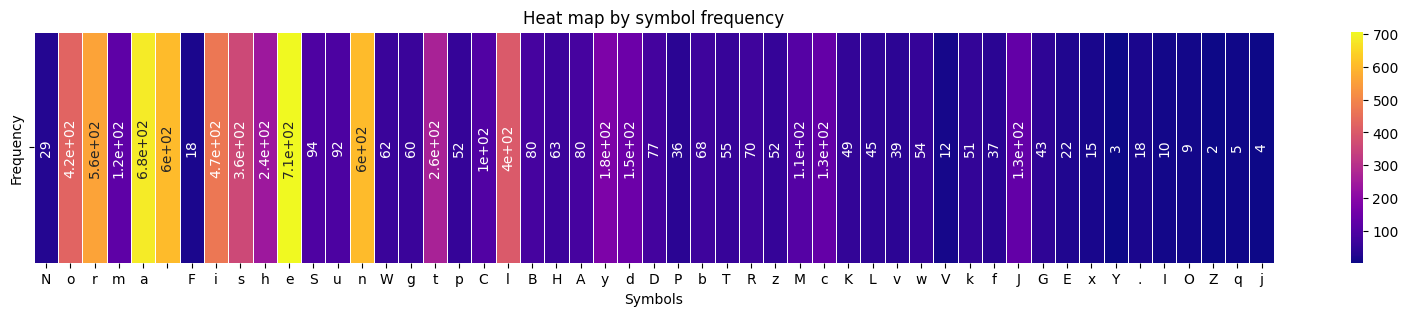

In [22]:
def count_char_frequencies(texts):
    freq = Counter()
    for text in texts:
        if not pd.isna(text):
            freq.update(text)
    return dict(freq)

frequencies = count_char_frequencies(df['Name'])

frq_matrix = pd.DataFrame.from_dict(frequencies, orient='index', columns=['Frequency'])
frq_matrix = frq_matrix.T
frq_matrix

plt.figure(figsize=(20, 3))
sns.heatmap(frq_matrix, annot=True, cmap='plasma', linewidths=0.5, annot_kws={'size': 10, 'rotation': 90})
plt.title('Heat map by symbol frequency')
plt.xlabel('Symbols')
plt.show()
